In [1]:
import numpy as np
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})

import scipy.linalg as spl
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
import xarray as xr

from waveeqn1D import WaveEquation

from utils import *
import nfft
import time

import copy

# Perturbation in $p$ (pressure) as a function of a perturbation in $N$ (stratification)

The formula reads:

\begin{equation}
\delta p = \sum_n e^{ik_nx}\sum_l \left[e^{i\omega_{n,l}t}+e^{-i\omega_{n,l}t}\right] \left( \dfrac{\delta C_{n,l}}{2} \tilde p_{n,l} + \dfrac{C_{n,l}}{2} \delta\tilde p_{n,l}\right) + \left[e^{i\omega_{n,l}t}-e^{-i\omega_{n,l}t}\right] it~\dfrac{C_{n,l}}{2}\tilde p_{n,l} \delta \omega_{n,l}
\label{eqn:perturbation}
\end{equation}

Where 

\begin{align}
\delta C_{n,l} &= \left<\sum_{j\neq l} \dfrac{\tilde p_{n,j}^H\delta A_n^H ~\tilde q_{n,l}}{\lambda^*_{n,l} - \lambda^*_{n,j}} \tilde q_{n,j},\hat p_0(k_n,\cdot)\right>\\
\delta\tilde p_{n,l} &= \sum_{j\neq l}\dfrac{\tilde q_{n,j}^H~\delta A_n ~\tilde p_{n,l}}{\lambda_{n,l} - \lambda_{n,j}}\tilde p_{n,j}\\
\delta \omega_{n,l} &= (\tilde q_{n,l}^H ~\delta A_n ~\tilde p_{n,l}) \dfrac{\omega^3_{n,l}}{2k_n^2}\\
\end{align}

and 
\begin{equation}
\delta A_n = -\mathrm{diag}\left(\dfrac{2\delta N}{N^3}(z)\right)\left(\mathbf{D}_2 - k_n^2\mathbf{I}\right)
\end{equation}


In [66]:
# Wave equation class to act as a ground truth (p_perturbed - p_control)
class InternalWaveEquation:
    def __init__(self,Lx=10e3,nx=1000,Lz=1e3,nz=100,Lt=3600,nt=60):
        #x mesh
        self.Lx = Lx #Length of the domain in x [m]
        self.nx = nx #Number of points in x
        self.X = np.linspace(0,self.Lx,self.nx)
        self.dx = self.X[1]-self.X[0] #horizontal discretization
        self.K = 2*np.pi*np.fft.fftfreq(self.nx,self.dx)
        
        #z mesh
        self.Lz = Lz #Depth of the domain [m]
        self.nz = nz #Number of points in z
        self.Z = np.linspace(0,self.Lz,self.nz)
        self.dz = self.Z[1]-self.Z[0] #vertical discretization
        
        #Temporal mesh 
        self.Lt = Lt #Length of the integration
        self.nt = nt #Number of points in time
        self.T = np.linspace(0,self.Lt,self.nt)
        self.dt = self.T[1]-self.T[0] #temporal discretization
        
    def I(self,x,z):
        x0=5e3;z0=200.
        zwidth=40
        xwidth=200
        return np.exp(-(z-z0)**2/2/zwidth**2-(x-x0)**2/2/xwidth**2)
        
    def set_N(self,N):
        assert len(N)==len(self.Z)
        self.N = N
    
    def An(self,k):
        D2 = make_D_fornberg(self.Z,2,npoints=3)
        B = D2 - k**2*np.eye(self.nz)
        
        #Neumann BCs
        hm1 = np.sqrt(-B[1,1])# B[1,1]=-1/h^2
        B[0]=0. ; B[0,0]  =-3*hm1; B[0,1]  = 4*hm1; B[0,2] =-hm1
        B[-1]=0.; B[-1,-1]= 3*hm1; B[-1,-2]=-4*hm1; B[-1,-3]=hm1
        
        return np.dot(np.diag(1/self.N**2),B)
        
    def eigenmodes(self,k): 
        """Compute the eigenmodes p_tilde_kn and associated eigenvalues. Could be sped up with sparse matrices & selecting leading vertical modes only"""
        A = self.An(k)
        
        lambdas,qtildes,ptildes=spl.eig(A,left=True) # The eigenvalues correspond to - k^2 * omega^-2, where omega is the eigenfrequency of each mode
        sortidx = np.argsort(lambdas)
        cutoff=-1 # Throw away non-oscillatory modes
        lambdas = np.real(lambdas[sortidx[:cutoff]])
        qtildes = qtildes[:,sortidx[:cutoff]]
        ptildes = ptildes[:,sortidx[:cutoff]]
        
        #Normalize adjoint eigenvectors
        qtildes = qtildes/np.diagonal(np.dot(qtildes.transpose().conj(),ptildes))[None,:].conj()
        
        return (lambdas,
                np.abs(k)/np.sqrt(-lambdas), # Vector of size nz-1
                qtildes,                     # Matrix of shape (nz,nz-1)
                ptildes,
               ) 
        
    def set_all_eigenmodes(self):
        self.qtildes = np.zeros((self.nx,self.nz-1,self.nz)) # Dimensions: k,n,z
        self.ptildes = np.zeros((self.nx,self.nz-1,self.nz)) # Dimensions: k,n,z
        self.omegas  = np.zeros((self.nx,self.nz-1))          # Dimensions: k,n
        self.lambdas = np.zeros((self.nx,self.nz-1))          # Dimensions: k,n
        for ik,k in enumerate(self.K):
            lambdas,omegas,qtildes,ptildes = self.eigenmodes(k)
            self.qtildes[ik] = qtildes.transpose()
            self.ptildes[ik] = ptildes.transpose()
            self.omegas[ik]  = omegas
            self.lambdas[ik] = lambdas
    
    def p0hat(self,ik):
        p0 = self.I(self.X[:,None],self.Z[None,:])
        return np.fft.fft(p0,axis=0)[ik]
        
    def integrate(self):
        self.set_all_eigenmodes()
        phat = 1j*np.zeros((self.nx,self.nz,self.nt))
        for ik,k in enumerate(self.K):
            if ik == 0:
                continue
            # Get mode coefficients
            Cn = np.dot(self.qtildes[ik],self.p0hat(ik))
            # define evaluation points for the nonuniform inverse fft
            fk = self.omegas[ik]*self.dt/2/np.pi        
            
            # Perform the nonuniform inverse fft in time, grid point by grid point
            for iz in range(self.nz):
                #phat[ik,iz,0] =  (Cn*self.ptildes[ik,:,iz]).sum()
                phat[ik,iz] =  nfft.nfft_adjoint(-fk, Cn/2*self.ptildes[ik,:,iz]*np.exp(-2*np.pi*1j*(self.nt//2)*fk), self.nt)
                phat[ik,iz]+=  nfft.nfft_adjoint( fk, Cn/2*self.ptildes[ik,:,iz]*np.exp( 2*np.pi*1j*(self.nt//2)*fk), self.nt)
        
        # Perform the inverse fft in x
        self.p = xr.DataArray(np.real(np.fft.ifft(phat,axis=0)),coords={'x':self.X,'z':self.Z,'time':self.T},dims=['x','z','time'])
        self.p_init = xr.DataArray(self.I(self.X[:,None],self.Z[None,:]),coords={'x':self.X,'z':self.Z},dims=['x','z'])
        

In [67]:
# Main class to compute delta p
class PerturbationPressure(InternalWaveEquation):
    def __init__(self, Lx=10e3,nx=1000,Lz=1e3,nz=100,Lt=3600,nt=60):
        super().__init__(Lx,nx,Lz,nz,Lt,nt)
    
    def set_deltaN(self,deltaN):
        assert len(deltaN)==len(self.Z)
        self.deltaN = deltaN
        #return 
    
    def deltaAn(self,k):
        D2 = make_D_fornberg(self.Z,2,npoints=5)
        deltaAn = -np.dot(np.diag(2*self.deltaN/self.N**3),D2 - k**2*np.eye(self.nz))
        deltaAn[0]=0.;deltaAn[-1]=0.
        return deltaAn
    
    def deltaptilde(self,ik,l,deltaAn):
        lambdas = self.lambdas[ik].copy()
        lambdas[l]=0 # dummy value to avoid dividing by 0
        fact= np.ones(len(lambdas))
        fact[l]=0
        return ( (fact * np.dot( np.dot(self.qtildes[ik],deltaAn) , self.ptildes[ik,l] ) /(self.lambdas[ik,l]-lambdas))[:,None]*self.ptildes[ik]).sum(axis=0) 
   
    def deltaqtilde(self,ik,l,deltaAn):
        lambdas = self.lambdas[ik].copy()
        lambdas[l]=0 # dummy value to avoid dividing by 0
        fact= np.ones(len(lambdas))
        fact[l]=0
        return (fact[:,None]* np.dot( np.dot(self.ptildes[ik],deltaAn.T.conj()) , self.qtildes[ik,l] )[:,None] /(self.lambdas[ik,l].conj()-lambdas.conj())[:,None]*self.qtildes[ik]).sum(axis=0) 
    
    def deltaomega(self,ik,l,deltaAn):
        return np.dot( np.dot(self.qtildes[ik,l],deltaAn) , self.ptildes[ik,l] ) * self.omegas[ik,l]**3/2/self.K[ik]**2
        
    def compute_deltap(self):
        self.set_all_eigenmodes()
        deltaphat = 1j*np.zeros((self.nx,self.nz,self.nt))
        self.deltaCn=[]
        for ik,k in enumerate(self.K):
            if ik == 0:
                continue
            # Get mode coefficients
            Cn = np.dot(self.qtildes[ik],self.p0hat(ik))
            # Get perturbation variables
            deltaAn_ = self.deltaAn(k)
            deltaCn = np.array([np.dot(self.deltaqtilde(ik,l,deltaAn_),self.p0hat(ik)) for l in range(self.qtildes.shape[1])])
            deltapntildes = np.array([self.deltaptilde(ik,l,deltaAn_) for l in range(self.qtildes.shape[1])])
            deltaomegans = np.array([self.deltaomega(ik,l,deltaAn_) for l in range(self.qtildes.shape[1])])
            self.deltaCn.append(deltaCn)
            # define evaluation points for the nonuniform inverse fft and temporal phase shift coefficients
            fk = self.omegas[ik]*self.dt/2/np.pi   
            phase_shift_minus = np.exp(-2*np.pi*1j*(self.nt//2)*fk)
            phase_shift_plus  = np.exp( 2*np.pi*1j*(self.nt//2)*fk)
            
            # Perform the nonuniform inverse fft in time, grid point by grid point
            for iz in range(self.nz):
                deltaphat[ik,iz] =            nfft.nfft_adjoint(-fk, (Cn/2*deltapntildes[:,iz]+deltaCn/2*self.ptildes[ik,:,iz]) * phase_shift_minus, self.nt)
                deltaphat[ik,iz]+=            nfft.nfft_adjoint( fk, (Cn/2*deltapntildes[:,iz]+deltaCn/2*self.ptildes[ik,:,iz]) * phase_shift_plus , self.nt)
                deltaphat[ik,iz]-= 1j*self.T* nfft.nfft_adjoint(-fk, (Cn/2*self.ptildes[ik,:,iz]*deltaomegans) * phase_shift_minus, self.nt)
                deltaphat[ik,iz]+= 1j*self.T* nfft.nfft_adjoint( fk, (Cn/2*self.ptildes[ik,:,iz]*deltaomegans) * phase_shift_plus , self.nt)
     
        # Perform the inverse fft in x
        self.deltap = xr.DataArray(np.real(np.fft.ifft(deltaphat,axis=0)),coords={'x':self.X,'z':self.Z,'time':self.T},dims=['x','z','time'])
        

# First test

In [7]:
# Compute delta w using perturbation theory
pvel = PerturbationPressure(Lt=3000,nt=100,nx=100,nz=50)
pvel.set_N(0.01*pvel.Z**0)
z0 = 100; sigma_z = 20; pvel.set_deltaN(np.exp(-((pvel.Z-z0)**2)/(2*sigma_z**2))*1e-4)   
%time pvel.compute_deltap()

/Users/quentin.nicolas/miniconda3/envs/macwaves/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in sqrt


CPU times: user 142 ms, sys: 6.21 ms, total: 149 ms
Wall time: 156 ms
CPU times: user 9.89 s, sys: 116 ms, total: 10 s
Wall time: 10.3 s


In [8]:
# Compute actual delta w

iwave = InternalWaveEquation(Lt=3000,nt=100,nx=100,nz=50)
iwave.set_N(0.01*iwave.Z**0)

iwave_pert = InternalWaveEquation(Lt=3000,nt=100,nx=100,nz=50)
iwave_pert.set_N(iwave.N + pvel.deltaN)

iwave.integrate()
iwave_pert.integrate()

/Users/quentin.nicolas/miniconda3/envs/macwaves/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in sqrt


CPU times: user 156 ms, sys: 6.31 ms, total: 162 ms
Wall time: 188 ms
CPU times: user 108 ms, sys: 1.78 ms, total: 110 ms
Wall time: 110 ms


## Few checks

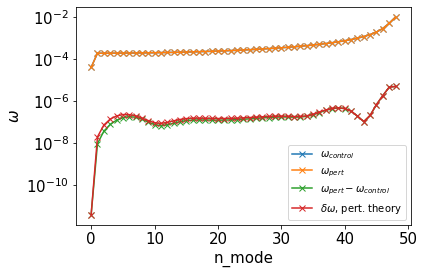

In [9]:
# Check that delta omega_n is accurate
n0=3
deltaAn_ = pvel.deltaAn(pvel.K[n0])
plt.plot(iwave.omegas[n0] ,'-x',label=r'$\omega_{control}$')
plt.plot(iwave_pert.omegas[n0],'-x',label=r'$\omega_{pert}$')
plt.plot(np.abs(iwave_pert.omegas[n0]-iwave.omegas[n0]),'-x',label=r'$\omega_{pert}-\omega_{control}$')
plt.plot([pvel.deltaomega(n0,l,deltaAn_) for l in range(49)],'-x',label=r'$\delta \omega$, pert. theory')
plt.yscale('log')
plt.xlabel('n_mode')
plt.ylabel(r'$\omega$')
plt.legend(fontsize=10)

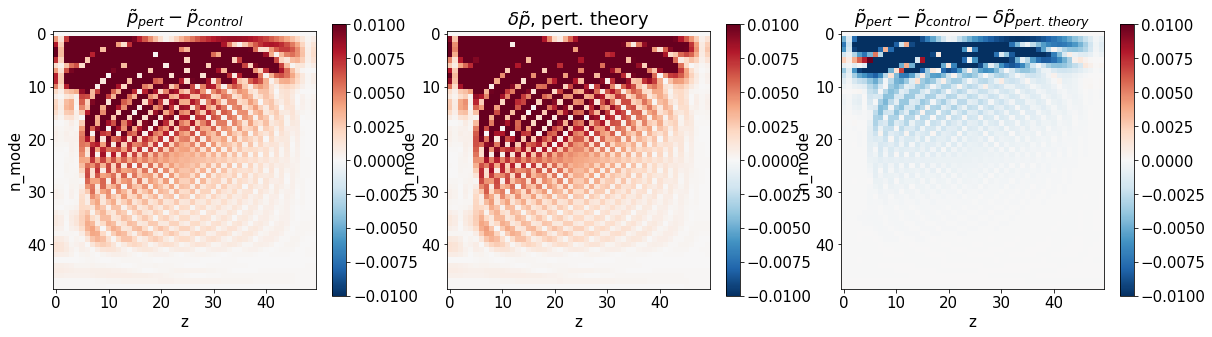

In [10]:
# Check that delta ptilde_n is accurate
# Need special care because the sign of the eigenvectors is set arbitrarily
# It is inaccurate in some regions (top right of the plot) but overall decent
deltas = np.zeros((49,50))
for n in range(49):
    delta1 = iwave_pert.ptildes[n0,n]-iwave.ptildes[n0,n]
    delta2 = iwave_pert.ptildes[n0,n]+iwave.ptildes[n0,n]
    if spl.norm(delta1)<spl.norm(delta2):
        deltas[n]=delta1
    else:
        deltas[n]=delta2
        
fig,axs=plt.subplots(1,3,figsize=(20,5))
scale=1e-2
        
ax=axs[0]
im=ax.imshow(np.abs(deltas),vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
fig.colorbar(im,ax=ax)
ax.set_title(r'$\tilde p_{pert} - \tilde p_{control}$')

deltaAn_ = pvel.deltaAn(pvel.K[n0])
deltas_analytical=np.array([pvel.deltaptilde(n0,l,deltaAn_) for l in range(49)])
ax=axs[1]
im=ax.imshow(np.abs(deltas_analytical),vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
fig.colorbar(im,ax=ax)
ax.set_title(r'$\delta \tilde p$, pert. theory')

ax=axs[2]
im=ax.imshow(np.abs(deltas)-np.abs(deltas_analytical),vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
fig.colorbar(im,ax=ax)
ax.set_title(r'$\tilde p_{pert} - \tilde p_{control} - \delta \tilde p_{pert. theory}$')

for a in axs:
    a.set_xlabel("z")
    a.set_ylabel("n_mode")

(1000.0, 0.0)

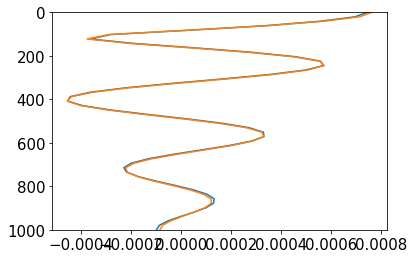

In [11]:
#checking individual eigenvectors
l=42
deltaAn_ = pvel.deltaAn(pvel.K[n0])
plt.plot((iwave_pert.ptildes[n0,l]-iwave.ptildes[n0,l]),iwave_pert.Z)
plt.plot(pvel.deltaptilde(n0,l,deltaAn_),pvel.Z)
plt.ylim(1000,0)

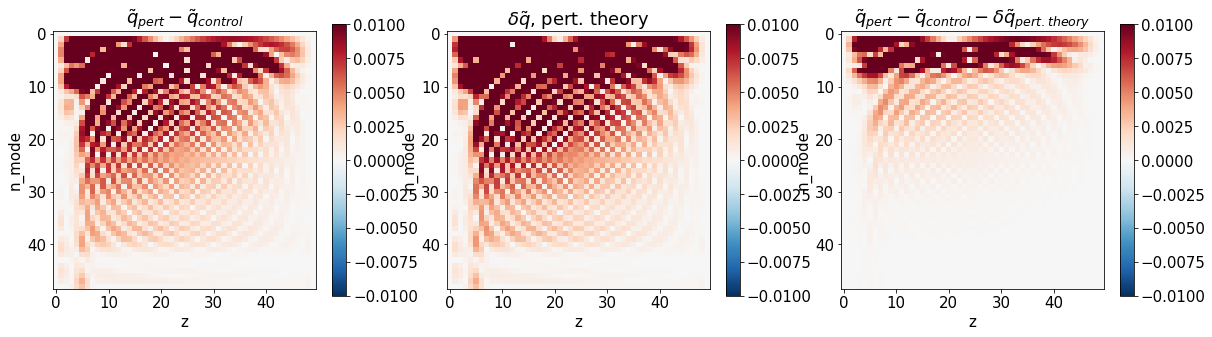

In [9]:
# Check that delta qtilde_n is accurate
# It is inaccurate in some regions 
deltas = np.zeros((49,50))
for n in range(49):
    delta1 = iwave_pert.qtildes[3,n]-iwave.qtildes[3,n]
    delta2 = iwave_pert.qtildes[3,n]+iwave.qtildes[3,n]
    if spl.norm(delta1)<spl.norm(delta2):
        deltas[n]=delta1
    else:
        deltas[n]=delta2
        
fig,axs=plt.subplots(1,3,figsize=(20,5))
scale=1e-2
        
ax=axs[0]
im=ax.imshow(np.abs(deltas),vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
fig.colorbar(im,ax=ax)
ax.set_title(r'$\tilde q_{pert} - \tilde q_{control}$')

deltaAn_ = pvel.deltaAn(pvel.K[n0])
deltas_analytical=np.array([pvel.deltaqtilde(3,l,deltaAn_) for l in range(49)])
ax=axs[1]
im=ax.imshow(np.abs(deltas_analytical),vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
fig.colorbar(im,ax=ax)
ax.set_title(r'$\delta \tilde q$, pert. theory')

ax=axs[2]
im=ax.imshow(np.abs(np.abs(deltas)-np.abs(deltas_analytical)),vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
fig.colorbar(im,ax=ax)
ax.set_title(r'$\tilde q_{pert} - \tilde q_{control} - \delta \tilde q_{pert. theory}$')
for a in axs:
    a.set_xlabel("z")
    a.set_ylabel("n_mode")

## Comparing perturbation theory solution against ground truth

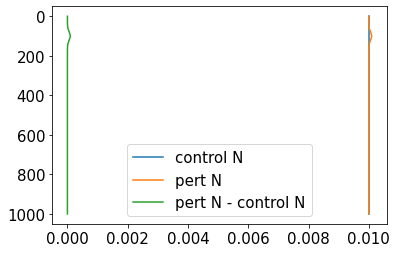

In [12]:
plt.plot(iwave.N,iwave.Z,label='control N')
plt.plot(iwave_pert.N,iwave_pert.Z,label='pert N')
plt.plot(iwave_pert.N-iwave.N,iwave_pert.Z,label='pert N - control N')
plt.gca().invert_yaxis()
plt.legend()

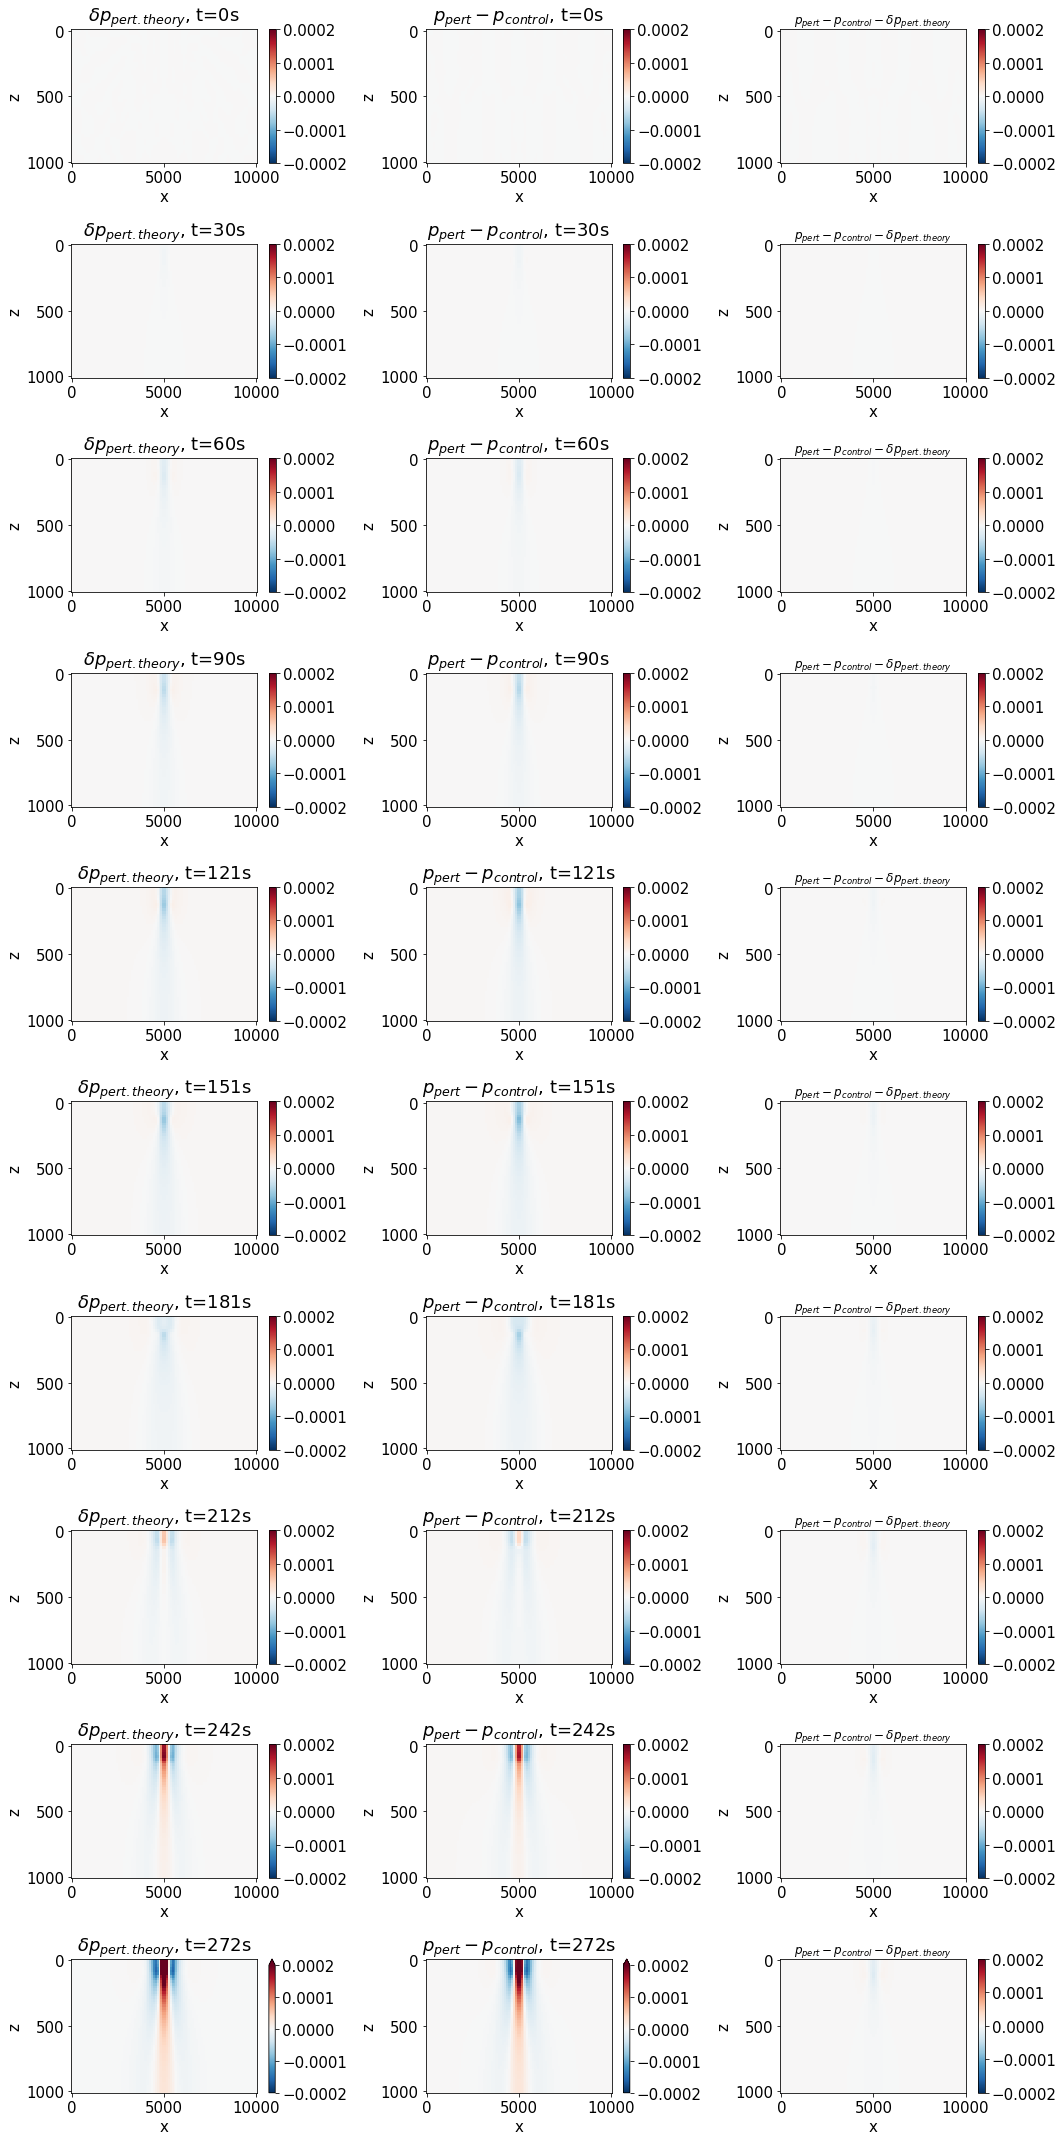

In [13]:
fig,ax=plt.subplots(10,3,figsize=(15,30))
scale=2e-4
for t in range(10):
    (pvel.deltap.isel(time=t)).plot(ax=ax[t,0],y='z',yincrease=False,vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
    (iwave_pert.p.isel(time=t)-iwave.p.isel(time=t)).plot(ax=ax[t,1],y='z',yincrease=False,vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
    (iwave_pert.p.isel(time=t)-iwave.p.isel(time=t)-(pvel.deltap.isel(time=t))).plot(ax=ax[t,2],y='z',yincrease=False,vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
    ax[t,0].set_title(r"$\delta p_{pert. theory}$, "+"t=%is"%iwave.p.time[t])
    ax[t,1].set_title(r"$p_{pert}-p_{control}$, "+"t=%is"%iwave.p.time[t])
    ax[t,2].set_title(r"$p_{pert}-p_{control}-\delta p_{pert. theory}$",fontsize=12)
fig.tight_layout()

# Second test

In [14]:
z0 = 100; sigma_z = 20
Nbase_test = lambda z: 0.01 +  np.exp(-((z-z0)**2)/(2*sigma_z**2))*0.01
deltaN_test = lambda z: np.exp(-((z-z0)**2)/(2*sigma_z**2))*1e-4

In [15]:
# Compute delta w using perturbation theory
pvel = PerturbationPressure(Lt=3000,nt=100,nx=100,nz=50)
pvel.set_N(Nbase_test(pvel.Z))
pvel.set_deltaN(deltaN_test(pvel.Z))
%time pvel.compute_deltap()

CPU times: user 146 ms, sys: 8.64 ms, total: 155 ms
Wall time: 171 ms
CPU times: user 10.5 s, sys: 157 ms, total: 10.6 s
Wall time: 11.1 s


In [17]:
# Compute actual delta w

iwave = InternalWaveEquation(Lt=3000,nt=100,nx=100,nz=50)
iwave.set_N(Nbase_test(iwave.Z))

iwave_pert = InternalWaveEquation(Lt=3000,nt=100,nx=100,nz=50)
iwave_pert.set_N(iwave.N + pvel.deltaN)

iwave.integrate()
iwave_pert.integrate()

CPU times: user 149 ms, sys: 3.95 ms, total: 153 ms
Wall time: 162 ms


/Users/quentin.nicolas/miniconda3/envs/macwaves/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in sqrt


CPU times: user 124 ms, sys: 2.1 ms, total: 126 ms
Wall time: 128 ms


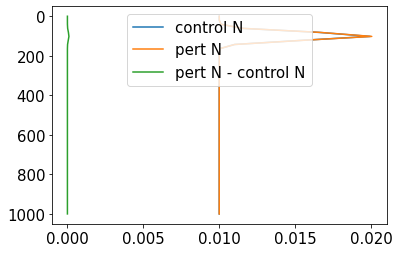

In [18]:
plt.plot(iwave.N,iwave.Z,label='control N')
plt.plot(iwave_pert.N,iwave_pert.Z,label='pert N')
plt.plot(iwave_pert.N-iwave.N,iwave_pert.Z,label='pert N - control N')
plt.gca().invert_yaxis()
plt.legend()

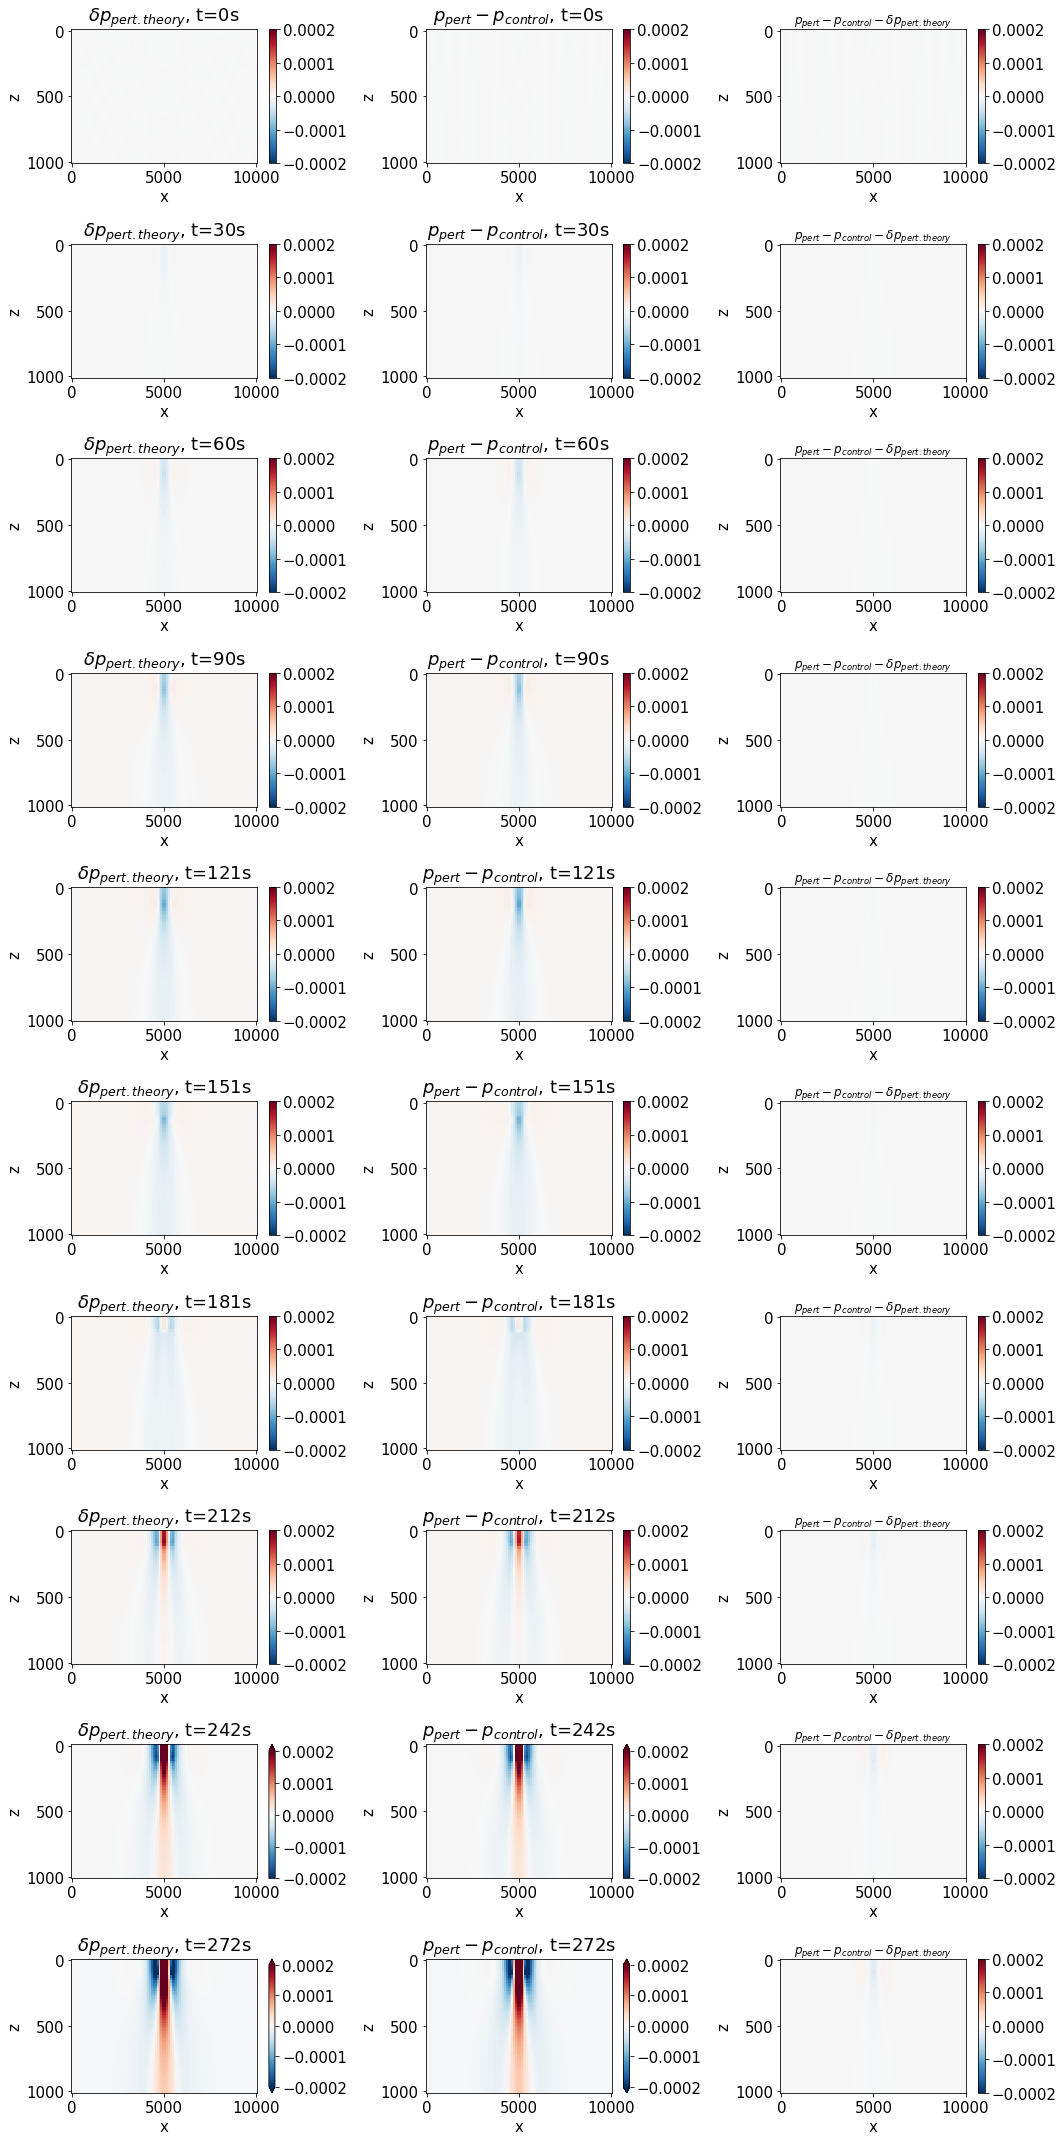

In [19]:
fig,ax=plt.subplots(10,3,figsize=(15,30))
scale=2e-4
for t in range(10):
    (pvel.deltap.isel(time=t)).plot(ax=ax[t,0],y='z',yincrease=False,vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
    (iwave_pert.p.isel(time=t)-iwave.p.isel(time=t)).plot(ax=ax[t,1],y='z',yincrease=False,vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
    (iwave_pert.p.isel(time=t)-iwave.p.isel(time=t)-(pvel.deltap.isel(time=t))).plot(ax=ax[t,2],y='z',yincrease=False,vmin=-scale,vmax=scale,cmap=plt.cm.RdBu_r)
    ax[t,0].set_title(r"$\delta p_{pert. theory}$, "+"t=%is"%iwave.p.time[t])
    ax[t,1].set_title(r"$p_{pert}-p_{control}$, "+"t=%is"%iwave.p.time[t])
    ax[t,2].set_title(r"$p_{pert}-p_{control}-\delta p_{pert. theory}$",fontsize=12)
fig.tight_layout()

# Tomography

 - Set locations of the pressure sensors
 - Set objective function $\chi$
 - Compute $\nabla\chi$ and $\nabla^2\chi$

In [58]:
from tqdm import tqdm

In [132]:
def compute_tomo(initial_model, pressure_measurements):
    """
    Parameters
    ----------
    initial_model : InternalWaveEquation object
        Contains the problem geometry and first-guess stratification
        
    pressure_measurements : xarray.DataArray
        Contains the data used to perform the inversion. dimensions are x and time; 
        all measurements are supposed to be taken on the seafloor (z=-H)
    
    Returns
    -------
    N : xarray.DataArray
        The stratification computed with tomography 
     """
    
    count_iter = 0 
    tol = 3e-4        # Treshold to define convergence
    max_iter = 5  
    
    initial_model.integrate()
    model = copy.deepcopy(initial_model)
    chi = objective_function(model,initial_model,pressure_measurements)
    
    while chi > tol:
        print(count_iter)
        if count_iter >= max_iter:
            print('Convergence failed')
            break
         # compute ds/dm
        
        hessian_chi,gradient_chi = grad_objective_function(model,initial_model,pressure_measurements)
        
        deltaN = - np.linalg.solve(hessian_chi,gradient_chi)
        model.set_N(model.N+deltaN)# update stratification
        model.integrate()
        chi = objective_function(model,initial_model,pressure_measurements)
        count_iter+=1
        
    return xr.DataArray(model.N,coords={'z':model.Z},dims=['z'])

def objective_function(model,initial_model,pressure_measurements):
    
    Cmm1 = 4*np.eye(initial_model.nz)
    m_minus_m0 = model.N-initial_model.N
    
    n_measures = len(np.array(pressure_measurements).reshape(-1))
    Cdm1 = np.eye(n_measures)
    s_minus_d = np.array(model.p.where(pressure_measurements).isel(z=-1) - pressure_measurements).reshape(-1)
    
    chi = 0.5* ( np.dot(m_minus_m0.T,np.dot(Cmm1,m_minus_m0)) + np.dot(s_minus_d.T,np.dot(Cdm1,s_minus_d)) )
    return chi
def grad_objective_function(model,initial_model,pressure_measurements):
    Cmm1 = 4*np.eye(initial_model.nz)
    m_minus_m0 = model.N-initial_model.N
    
    n_measures = len(np.array(pressure_measurements).reshape(-1))
    Cdm1 = np.eye(n_measures)
    s_minus_d = np.array(model.p.where(pressure_measurements).isel(z=-1) - pressure_measurements).reshape(-1)
    
    ## Get dp/dN
    deltap = PerturbationPressure(model.Lx,model.nx,model.Lz,model.nz,model.Lt,model.nt)
    deltap.set_N(model.N)
    
    dpdN = np.zeros((n_measures,model.nz))
    for iz in tqdm(range(model.nz)):
        dN = np.zeros(model.nz)
        dN[iz]=1
        deltap.set_deltaN(dN)
        deltap.compute_deltap()
        dpdN[:,iz] = np.array(deltap.deltap.where(pressure_measurements).isel(z=-1)).reshape(-1)

    grad_chi = np.dot(Cmm1,m_minus_m0) + np.dot(dpdN.T,np.dot(Cdm1,s_minus_d))
    hessian_chi = Cmm1 + np.dot(dpdN.T,np.dot(Cdm1,dpdN))
    return hessian_chi,grad_chi
        

In [133]:
z0 = 100; sigma_z = 20
Nbase = lambda z: 0.01 +  np.exp(-((z-z0)**2)/(2*sigma_z**2))*0.01
Ninitial = lambda z: 0.01*z**0

In [134]:
initial_model = InternalWaveEquation(Lt=1000,nt=50,nx=25,nz=20)
initial_model.set_N(Ninitial(initial_model.Z))

synthetic_model = InternalWaveEquation(Lt=1000,nt=50,nx=25,nz=20)
synthetic_model.set_N(Nbase(synthetic_model.Z))

%time initial_model.integrate()
%time synthetic_model.integrate()



/Users/quentin.nicolas/miniconda3/envs/macwaves/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in sqrt


CPU times: user 459 ms, sys: 6.77 ms, total: 465 ms
Wall time: 482 ms
CPU times: user 409 ms, sys: 2.16 ms, total: 411 ms
Wall time: 419 ms


In [135]:
pmeas = synthetic_model.p[::7,-1]

In [136]:
objective_function(initial_model,initial_model,pmeas)

0.006148308999184194

In [137]:
objective_function(synthetic_model,initial_model,pmeas)

0.00018739683261499176

In [138]:
%time Ntest = compute_tomo(initial_model, pmeas)

/Users/quentin.nicolas/miniconda3/envs/macwaves/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in sqrt


0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.29it/s]


CPU times: user 16.8 s, sys: 221 ms, total: 17 s
Wall time: 16.4 s


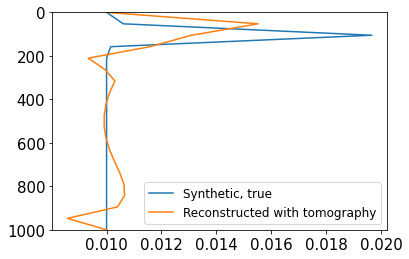

In [142]:
plt.plot(synthetic_model.N,synthetic_model.Z,label='Synthetic, true')
plt.plot(Ntest,synthetic_model.Z,label='Reconstructed with tomography')
plt.ylim(1000,0)
plt.legend(loc=4,fontsize=12)

(1000.0, 0.0)

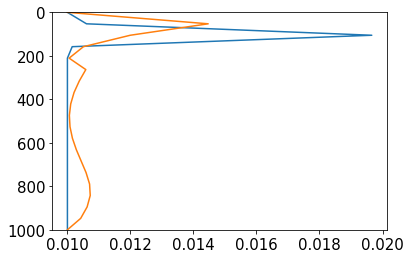

In [89]:
plt.plot(synthetic_model.N,synthetic_model.Z)
plt.plot(Ntest,synthetic_model.Z)
plt.ylim(1000,0)

(1000.0, 0.0)

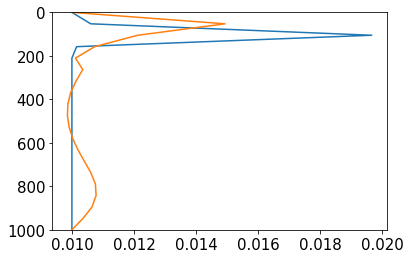

In [86]:
plt.plot(synthetic_model.N,synthetic_model.Z)
plt.plot(Ntest,synthetic_model.Z)
plt.ylim(1000,0)